# Biophysical Variable Prediction in Scikit-Learn and Keras using PROSAIL Sentinel 2 Band Simulated Database
---

## Introduction
---

### Background
*Similar background to ALR paper*

### Objectives
The main objective of this paper is to compare the performance of SL2P(D) against the performance of a purely linear model which performs variable selection on the input bands, as well as the performance of the same linear model with the addition of a neural network which performs regression on the features selected by the linear model. In this case the feature selection will be performed by the least angle regression algorithm (Efron et al., 2002) provided by scikit-learn.

Specifically performance will be measured using the root mean squared error of each model as well as the absolute error in the model with respect to the specific true value of the response variables.

## Methodology
---

### Methods
Three methods were tested on the global PROSAIL dataset with 41472 samples simulated from various different biomes to estimate LAI, FCOVER, and FAPAR.
* SL2P
* LARS Regression
* LARS Regression + Keras (Tensorflow) Shallow Neural Network

The PROSAIL simulation generates Sentinel 2 bands:

| Band | Central Wavelength | Description | Resolution | 
|---|---|---|---|
| B3 | 560nm | green | 10m |
| B4 | 665nm | red | 10m |
| B5 | 705nm | VNIR | 20m res |
| B6 | 740nm | VNIR | 20m res |
| B7 | 783nm | VNIR | 20m res |
| B8A | 865nm | VNIR | 20m res |
| B11 | 1610nm | SWIR | 20m res |
| B12 | 2190nm | SWIR | 20m res |

*SL2P description* + `code`

In the script below the methodology used for LARS and the shallow neural network in Keras will be described further.

In [1]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy 
import pandas 
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
matlabData = sio.loadmat(file_name='./data/s2_sl2p_weiss_or_prosail_inout.mat', variable_names=['Input', 'Output'])

In [4]:
inputDF = pandas.DataFrame(data=matlabData['Input']['Rho_Toc'][0][0])
inputAngles = pandas.DataFrame(data=matlabData['Input']['Angles'][0][0])

inputDF = pandas.concat([inputDF, inputAngles], axis=1, join='outer', ignore_index=True)
inputDF.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3']

LAI = pandas.Series(data=matlabData['Output']['LAI'][0][0].flatten())
FAPAR = pandas.Series(data=matlabData['Output']['FAPAR'][0][0].flatten())
FCOVER = pandas.Series(data=matlabData['Output']['FCOVER'][0][0].flatten())

outputCSV = pandas.concat([inputDF, LAI, FAPAR, FCOVER], axis=1, join='outer')
outputCSV['latitude'] = 0
outputCSV['longitude'] = 0
outputCSV.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 
                     'LAI', 'FAPAR', 'FCOVER', 'latitude', 'longitude']
outputCSV

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,latitude,longitude
0,0.048953,0.030271,0.073742,0.294630,0.419698,0.436037,0.121603,0.043615,0.994435,0.853211,0.994632,6.014594,0.870412,0.875424,0,0
1,0.053655,0.029552,0.074523,0.383288,0.566787,0.597187,0.180981,0.054689,0.974949,0.899428,-0.974783,5.752335,0.957268,0.971936,0,0
2,0.075767,0.092849,0.144840,0.267414,0.306598,0.321708,0.254556,0.145838,0.970282,0.901471,0.982456,0.746137,0.386350,0.394260,0,0
3,0.071742,0.031115,0.094643,0.303518,0.383710,0.391068,0.118468,0.047038,0.987971,0.865112,-0.997234,5.374681,0.819419,0.830017,0,0
4,0.100043,0.028230,0.130998,0.442701,0.560120,0.563746,0.182785,0.062757,0.961521,0.385027,0.490117,5.467322,0.899630,0.927706,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41467,0.091781,0.028950,0.124602,0.420813,0.528081,0.544847,0.122709,0.032790,0.979430,0.704338,0.746313,4.951841,0.922245,0.949148,0,0
41468,0.046467,0.034942,0.069040,0.229278,0.308859,0.321834,0.126807,0.071680,0.994707,0.654700,-0.672963,4.453112,0.717015,0.714964,0,0
41469,0.045621,0.027923,0.067862,0.307144,0.445989,0.474847,0.162763,0.055750,0.999777,0.576598,-0.587336,4.579922,0.861480,0.871602,0,0
41470,0.053039,0.037354,0.081990,0.340293,0.506438,0.528001,0.190817,0.076028,0.988945,0.729268,0.771352,5.502935,0.879030,0.882815,0,0


In [5]:
#outputCSV.to_csv(path_or_buf=r'rawFeatures.csv')

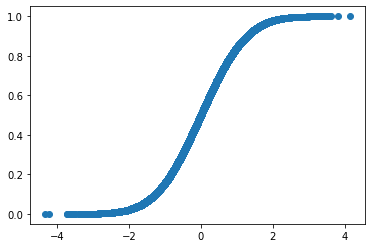

In [6]:
# Create probability distribution # 

# Number of data points used
N = outputCSV.shape[0]
  
# Create a normal distribution 
norm_dis = numpy.random.randn(N)
  
# Sort the data in ascending order
samples = numpy.sort(norm_dis)
  
# Get the cdf values of samples
prob = numpy.arange(N) / float(N)

plt.scatter(samples, prob)
plt.show()

In [7]:
inputDF_centred = inputDF - inputDF.mean()
inputDF_normed = inputDF_centred * inputDF_centred.pow(2).sum().pow(-0.5)

LAI_mean = LAI.mean()
FAPAR_mean = FAPAR.mean()
FCOVER_mean = FCOVER.mean()

LAI_centred = LAI.subtract(LAI_mean)
FAPAR_centred = FAPAR.subtract(FAPAR_mean)
FCOVER_centred = FCOVER.subtract(FCOVER_mean)

outputCSV_scaled = pandas.concat([inputDF_normed, LAI_centred, FAPAR_centred, FCOVER_centred], axis=1, join='outer')
#outputCSV_scaled['latitude'] = 0
#outputCSV_scaled['longitude'] = 0
outputCSV_scaled['prob'] = prob
outputCSV_scaled.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 
                     'LAI', 'FAPAR', 'FCOVER', 'prob']
outputCSV_scaled

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,prob
0,-0.004782,-0.003073,-0.004367,-0.000890,0.000502,0.000372,-0.006157,-0.004899,0.004487,0.004357,0.006255,2.730060,0.197899,0.196068,0.000000
1,-0.003899,-0.003175,-0.004265,0.003712,0.005732,0.006026,-0.001843,-0.004107,-0.003168,0.005860,-0.006390,2.467801,0.284755,0.292580,0.000024
2,0.000253,0.005743,0.004929,-0.002303,-0.003520,-0.003640,0.003502,0.002413,-0.005001,0.005927,0.006177,-2.538397,-0.286164,-0.285096,0.000048
3,-0.000503,-0.002954,-0.001634,-0.000429,-0.000778,-0.001206,-0.006385,-0.004654,0.001948,0.004744,-0.006534,2.090147,0.146906,0.150661,0.000072
4,0.004810,-0.003361,0.003119,0.006796,0.005495,0.004853,-0.001712,-0.003530,-0.008443,-0.010873,0.003016,2.182788,0.227116,0.248350,0.000096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41467,0.003259,-0.003259,0.002283,0.005660,0.004356,0.004190,-0.006077,-0.005673,-0.001407,-0.000486,0.004660,1.667307,0.249732,0.269792,0.999879
41468,-0.005248,-0.002415,-0.004982,-0.004283,-0.003439,-0.003636,-0.005779,-0.002892,0.004594,-0.002100,-0.004452,1.168578,0.044502,0.035608,0.999904
41469,-0.005407,-0.003404,-0.005136,-0.000241,0.001437,0.001734,-0.003167,-0.004031,0.006586,-0.004641,-0.003902,1.295389,0.188966,0.192247,0.999928
41470,-0.004014,-0.002075,-0.003288,0.001480,0.003586,0.003599,-0.001129,-0.002581,0.002330,0.000325,0.004821,2.218401,0.206517,0.203459,0.999952


In [8]:
# Training Data #

training_data = outputCSV_scaled.sample(n=10000, weights=outputCSV_scaled["prob"], replace=False, ignore_index=True)

training_data

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,prob
0,0.003499,0.009369,0.003657,-0.007417,-0.007725,-0.007686,0.003071,0.007380,-0.000054,-0.004792,-0.003383,-2.546675,-0.510773,-0.554666,0.827498
1,-0.001809,-0.002760,-0.001615,0.004122,0.004966,0.004999,0.004266,0.000149,-0.005772,-0.004424,0.003584,0.484028,0.178603,0.185527,0.446856
2,-0.001931,0.000663,0.000289,-0.002815,-0.003661,-0.003867,-0.000981,-0.001306,-0.000319,0.004070,0.006260,-2.209203,-0.184381,-0.175855,0.197844
3,0.006098,0.001480,0.007146,0.002940,0.000905,0.000772,-0.000262,-0.001485,-0.005244,0.001821,-0.005140,-0.018367,0.066683,0.077533,0.560692
4,0.005233,-0.002129,0.004493,0.000113,-0.001679,-0.001649,-0.000540,-0.001755,0.006571,-0.004790,-0.003610,-1.435756,-0.053017,-0.009761,0.273655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.002929,-0.003286,-0.002918,0.000242,0.000147,0.000486,-0.000412,-0.002660,0.002800,0.003834,-0.006037,-0.823466,0.095256,0.109161,0.933546
9996,0.012890,0.010105,0.012661,0.002737,0.000210,0.000125,0.006717,0.007458,0.000454,-0.009249,0.003205,-1.962487,-0.179182,-0.200680,0.926384
9997,-0.005326,-0.003684,-0.005836,-0.000945,0.000127,-0.000264,-0.006345,-0.005210,0.001478,0.006286,-0.006106,0.141421,0.117922,0.122558,0.959298
9998,-0.001559,-0.003223,-0.002148,0.003797,0.004245,0.004171,0.003638,-0.000071,-0.001191,-0.009011,0.003238,0.195374,0.166516,0.176096,0.314164


In [9]:
# Validation Data #

valid_data = outputCSV_scaled.sample(n=2000, weights=outputCSV_scaled["prob"], replace=False, ignore_index=True)

valid_data

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,prob
0,0.000615,0.001804,-0.000900,-0.006250,-0.006727,-0.007087,-0.002363,0.000768,0.000167,-0.004044,0.003959,-2.350647,-0.314213,-0.321262,0.482350
1,0.001420,-0.003693,0.000391,0.004510,0.004074,0.003723,-0.003970,-0.004694,0.006646,0.004456,0.005969,2.851752,0.252046,0.266083,0.757837
2,-0.003570,-0.002515,-0.003764,-0.002885,-0.002877,-0.002739,-0.004475,-0.002589,0.003439,0.005280,0.005410,-1.041821,-0.003240,0.003074,0.857205
3,0.004458,-0.001662,0.003015,0.004972,0.003407,0.003017,-0.000695,-0.001440,0.002234,0.005453,0.006172,0.569186,0.171186,0.182858,0.746648
4,-0.004427,-0.002505,-0.004133,-0.000118,0.000566,0.001253,0.000077,-0.002116,-0.010161,0.004870,0.005451,-1.426790,0.065535,0.073715,0.565201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.003641,0.007588,0.006564,-0.003203,-0.004051,-0.003128,0.010996,0.011444,-0.007118,-0.003303,-0.004192,-2.329618,-0.362130,-0.383847,0.318697
1996,-0.006009,-0.003396,-0.005532,-0.002959,-0.002195,-0.002445,-0.008727,-0.005780,0.004790,-0.007482,-0.003525,0.803202,0.108714,0.110451,0.875289
1997,0.001199,-0.001177,0.000924,0.005504,0.004317,0.003671,0.003588,0.000353,-0.005412,0.003426,-0.005700,-0.586223,0.132952,0.146853,0.396195
1998,0.003268,0.003131,0.002355,-0.003233,-0.003888,-0.003598,0.006516,0.009634,0.001943,-0.006130,-0.003506,-0.845796,-0.148568,-0.181667,0.926842


In [10]:
#outputCSV_scaled.to_csv(path_or_buf=r'scaledFeatures.csv')

In [11]:
LAI_training = training_data['LAI']
FAPAR_training = training_data['FAPAR']
FCOVER_training = training_data['FCOVER']

In [12]:
LAI_valid = valid_data['LAI']
FAPAR_valid = valid_data['FAPAR']
FCOVER_valid = valid_data['FCOVER']

In [13]:
training_data = training_data.drop(['LAI', 'FAPAR', 'FCOVER'], axis=1)
valid_data = valid_data.drop(['LAI', 'FAPAR', 'FCOVER'], axis=1)

In [14]:
LAImodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
LAImodel = LAImodel.fit(training_data, LAI_training)

FAPARmodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
FAPARmodel = FAPARmodel.fit(training_data, FAPAR_training)

FCOVERmodel = sklearn.linear_model.Lars(n_nonzero_coefs=11)
FCOVERmodel = FCOVERmodel.fit(training_data, FCOVER_training)

In [15]:
LAI_predicted = pandas.Series(LAImodel.predict(valid_data))
FAPAR_predicted = pandas.Series(FAPARmodel.predict(valid_data))
FCOVER_predicted = pandas.Series(FCOVERmodel.predict(valid_data))

In [16]:
LAI_RMSE = sklearn.metrics.mean_squared_error(LAI_valid, LAI_predicted, squared=False)
FAPAR_RMSE = sklearn.metrics.mean_squared_error(FAPAR_valid, FAPAR_predicted, squared=False)
FCOVER_RMSE = sklearn.metrics.mean_squared_error(FCOVER_valid, FCOVER_predicted, squared=False)

In [17]:
print('LAI Coefficient Path - RMSE: {}'.format(LAI_RMSE))
pandas.DataFrame(LAImodel.coef_path_)

LAI Coefficient Path - RMSE: 4.373268135366934


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.615244,109.874462
1,0.0,0.000000,0.000000,-14.624584,8.491651,145.845305,175.370939,400.331293,610.603960,844.487253,1044.062943,1396.891850
2,0.0,0.000000,0.000000,0.000000,-27.969980,-95.008482,-109.155271,-216.547386,-465.256030,-801.231096,-1111.068968,-1658.928052
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,499.074778,1284.150213,1903.478377,2998.236198
4,0.0,32.268289,45.784854,88.710182,111.747590,155.246595,142.213598,27.339872,-571.359545,-1966.616272,-3097.614900,-5096.527790
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,22.176501,216.551306,439.355562,1219.135009,1854.654532,2977.708460
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-18.864906,-47.309694,-122.149174,-160.701093,-228.736984
7,0.0,0.000000,-13.516565,-45.537939,-53.278903,-121.215483,-136.426294,-233.961348,-249.255777,-211.226364,-208.978781,-205.171373
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.955468
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
print('FAPAR Coefficient Path - RMSE: {}'.format(FAPAR_RMSE))
pandas.DataFrame(FAPARmodel.coef_path_)

FAPAR Coefficient Path - RMSE: 0.0535953777653676


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170896,0.210419,0.423673,0.886874
1,0.0,0.000000,-3.427021,-5.407159,-5.137295,-4.715131,-4.589144,-4.548937,-4.468858,-4.450307,-4.350265,-1.961837
2,0.0,0.000000,0.000000,0.000000,-0.312665,-1.331474,-1.306132,-1.297919,-1.485073,-1.528410,-1.762177,-5.871718
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.822899
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-6.373502,-8.406655,-9.539332,-9.800701,-11.211398,-28.250281
5,0.0,7.275859,10.702880,17.541379,17.798681,20.977264,27.624139,29.744602,30.876862,31.138130,32.548248,42.546127
6,0.0,0.000000,0.000000,0.000000,0.000000,-4.177281,-4.807826,-5.009051,-5.021091,-5.023826,-5.038574,-5.854774
7,0.0,0.000000,0.000000,-5.379052,-5.477644,-1.330612,-0.986693,-0.876996,-0.938981,-0.953331,-1.030750,-0.534624
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008528,0.013700,0.014895,0.021345,0.065286
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
print('FCOVER Coefficient Path - RMSE: {}'.format(FCOVER_RMSE))
pandas.DataFrame(FCOVERmodel.coef_path_)

FCOVER Coefficient Path - RMSE: 0.04990339370305699


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.059718,0.060554,0.088811,0.134623,0.142618,0.524471
1,0.0,0.000000,-4.081146,-6.182273,-6.709586,-6.571019,-6.566573,-6.566511,-6.564434,-6.561006,-6.557256,-4.588284
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008763,-3.396585
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.273418
4,0.0,0.000000,0.000000,0.000000,0.000000,-5.836394,-7.995672,-8.025847,-9.042969,-10.696780,-10.749664,-24.796172
5,0.0,6.908875,10.990021,18.246363,20.791122,26.884710,29.102193,29.133180,30.177690,31.876143,31.929005,40.171052
6,0.0,0.000000,0.000000,0.000000,-3.970853,-4.541138,-4.737722,-4.740468,-4.833003,-4.983621,-4.984174,-5.657033
7,0.0,0.000000,0.000000,-5.707721,-1.712128,-1.405641,-1.310871,-1.309548,-1.265011,-1.192361,-1.195263,-0.786267
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004413,0.011593,0.011835,0.048059
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
LAImodel = sklearn.linear_model.Lars(n_nonzero_coefs=4)
LAImodel = LAImodel.fit(training_data, LAI_training)

FAPARmodel = sklearn.linear_model.Lars(n_nonzero_coefs=4)
FAPARmodel = FAPARmodel.fit(training_data, FAPAR_training)

FCOVERmodel = sklearn.linear_model.Lars(n_nonzero_coefs=3)
FCOVERmodel = FCOVERmodel.fit(training_data, FCOVER_training)

In [21]:
LAI_predicted = pandas.Series(LAImodel.predict(valid_data))
FAPAR_predicted = pandas.Series(FAPARmodel.predict(valid_data))
FCOVER_predicted = pandas.Series(FCOVERmodel.predict(valid_data))

In [22]:
LAI_features = numpy.nonzero(LAImodel.coef_)[0]
FAPAR_features = numpy.nonzero(FAPARmodel.coef_)[0]
FCOVER_features = numpy.nonzero(FCOVERmodel.coef_)[0]

LAI_features = valid_data.columns[LAI_features]
FAPAR_features = valid_data.columns[FAPAR_features]
FCOVER_features = valid_data.columns[FCOVER_features]

In [23]:
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(training_data[LAI_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])


FAPAR_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(training_data[FAPAR_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
FAPAR_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])


FCOVER_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid, 
                                  input_shape=[len(training_data[FCOVER_features].keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.sigmoid),
    tensorflow.keras.layers.Dense(1)
])
FCOVER_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [24]:
# Use the sampled inputDF and sampled testing DF.

LAI_model.fit(x = training_data[LAI_features], y = LAI_training, epochs = 100, validation_data = (valid_data[LAI_features], LAI_valid))

Train on 10000 samples, validate on 2000 samples
Epoch 1/100
10000/10000 [==============================] - 5s 468us/sample - loss: 4.8802 - mse: 4.8802 - mae: 1.7924 - val_loss: 4.9689 - val_mse: 4.9689 - val_mae: 1.8187
Epoch 2/100
10000/10000 [==============================] - 2s 161us/sample - loss: 4.8505 - mse: 4.8505 - mae: 1.7808 - val_loss: 4.9751 - val_mse: 4.9751 - val_mae: 1.8124
Epoch 3/100
10000/10000 [==============================] - 2s 169us/sample - loss: 4.8478 - mse: 4.8478 - mae: 1.7778 - val_loss: 4.9592 - val_mse: 4.9592 - val_mae: 1.8181
Epoch 4/100
10000/10000 [==============================] - 2s 170us/sample - loss: 4.8414 - mse: 4.8414 - mae: 1.7788 - val_loss: 4.9577 - val_mse: 4.9577 - val_mae: 1.8124
Epoch 5/100
10000/10000 [==============================] - 2s 163us/sample - loss: 4.8346 - mse: 4.8346 - mae: 1.7756 - val_loss: 4.9442 - val_mse: 4.9442 - val_mae: 1.8165
Epoch 6/100
10000/10000 [==============================] - 1s 148us/sample - loss: 4.8

In [25]:
FAPAR_model.fit(x = training_data[FAPAR_features], y = FAPAR_training, epochs = 20, validation_data = (valid_data[FAPAR_features], FAPAR_valid))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 470us/sample - loss: 0.0664 - mse: 0.0664 - mae: 0.2146 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.2132
Epoch 2/20
10000/10000 [==============================] - 1s 147us/sample - loss: 0.0653 - mse: 0.0653 - mae: 0.2121 - val_loss: 0.0651 - val_mse: 0.0651 - val_mae: 0.2174
Epoch 3/20
10000/10000 [==============================] - 1s 145us/sample - loss: 0.0643 - mse: 0.0643 - mae: 0.2107 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.2096
Epoch 4/20
10000/10000 [==============================] - 1s 143us/sample - loss: 0.0632 - mse: 0.0632 - mae: 0.2086 - val_loss: 0.0633 - val_mse: 0.0633 - val_mae: 0.2157
Epoch 5/20
10000/10000 [==============================] - 1s 148us/sample - loss: 0.0619 - mse: 0.0619 - mae: 0.2066 - val_loss: 0.0611 - val_mse: 0.0611 - val_mae: 0.2095
Epoch 6/20
10000/10000 [==============================] - 1s 141us/sample - loss: 0.0603 - 

In [26]:
FCOVER_model.fit(x = training_data[FCOVER_features], y = FCOVER_training, epochs = 20, validation_data = (valid_data[FCOVER_features], FCOVER_valid))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 3s 282us/sample - loss: 0.1494 - mse: 0.1494 - mae: 0.3072 - val_loss: 0.0713 - val_mse: 0.0713 - val_mae: 0.2243
Epoch 2/20
10000/10000 [==============================] - 1s 93us/sample - loss: 0.0709 - mse: 0.0709 - mae: 0.2224 - val_loss: 0.0707 - val_mse: 0.0707 - val_mae: 0.2223
Epoch 3/20
10000/10000 [==============================] - 1s 83us/sample - loss: 0.0704 - mse: 0.0704 - mae: 0.2215 - val_loss: 0.0702 - val_mse: 0.0702 - val_mae: 0.2237
Epoch 4/20
10000/10000 [==============================] - 1s 86us/sample - loss: 0.0697 - mse: 0.0697 - mae: 0.2206 - val_loss: 0.0694 - val_mse: 0.0694 - val_mae: 0.2210
Epoch 5/20
10000/10000 [==============================] - 1s 99us/sample - loss: 0.0690 - mse: 0.0690 - mae: 0.2192 - val_loss: 0.0693 - val_mse: 0.0693 - val_mae: 0.2251
Epoch 6/20
10000/10000 [==============================] - 1s 93us/sample - loss: 0.0682 - mse: 

In [27]:
LAI_predictions = pandas.Series(LAI_model.predict(valid_data[LAI_features]).flatten())
FAPAR_predictions = pandas.Series(FAPAR_model.predict(valid_data[FAPAR_features]).flatten())
FCOVER_predictions = pandas.Series(FCOVER_model.predict(valid_data[FCOVER_features]).flatten())

In [28]:
xy_skl_LAI = numpy.vstack([LAI_valid, LAI_predicted])
xy_tf_LAI = numpy.vstack([LAI_valid, LAI_predictions])

xy_skl_FAPAR = numpy.vstack([FAPAR_valid, FAPAR_predicted])
xy_tf_FAPAR = numpy.vstack([FAPAR_valid, FAPAR_predictions])

xy_skl_FCOVER = numpy.vstack([FCOVER_valid, FCOVER_predicted])
xy_tf_FCOVER = numpy.vstack([FCOVER_valid, FCOVER_predictions])

In [29]:
z_skl_LAI = scipy.stats.gaussian_kde(xy_skl_LAI)(xy_skl_LAI)
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

z_skl_FAPAR = scipy.stats.gaussian_kde(xy_skl_FAPAR)(xy_skl_FAPAR)
z_tf_FAPAR = scipy.stats.gaussian_kde(xy_tf_FAPAR)(xy_tf_FAPAR)

z_skl_FCOVER = scipy.stats.gaussian_kde(xy_skl_FCOVER)(xy_skl_FCOVER)
z_tf_FCOVER = scipy.stats.gaussian_kde(xy_tf_FCOVER)(xy_tf_FCOVER)

In [30]:
idx_skl_LAI = z_skl_LAI.argsort()
idx_tf_LAI = z_tf_LAI.argsort()

idx_skl_FAPAR = z_skl_FAPAR.argsort()
idx_tf_FAPAR = z_tf_FAPAR.argsort()

idx_skl_FCOVER = z_skl_FCOVER.argsort()
idx_tf_FCOVER = z_tf_FCOVER.argsort()

In [31]:
x_skl_LAI = LAI_valid[idx_skl_LAI]
x_tf_LAI = LAI_valid[idx_tf_LAI]

x_skl_FAPAR = FAPAR_valid[idx_skl_FAPAR]
x_tf_FAPAR = FAPAR_valid[idx_tf_FAPAR]

x_skl_FCOVER = FCOVER_valid[idx_skl_FCOVER]
x_tf_FCOVER = FCOVER_valid[idx_tf_FCOVER]

In [32]:
y_skl_LAI = LAI_predicted[idx_skl_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]

y_skl_FAPAR = FAPAR_predicted[idx_skl_FAPAR]
y_tf_FAPAR = FAPAR_predictions[idx_tf_FAPAR]

y_skl_FCOVER = FCOVER_predicted[idx_skl_FCOVER]
y_tf_FCOVER = FCOVER_predictions[idx_tf_FCOVER]

In [33]:
z_skl_LAI = z_skl_LAI[idx_skl_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

z_skl_FAPAR = z_skl_FAPAR[idx_skl_FAPAR]
z_tf_FAPAR = z_tf_FAPAR[idx_tf_FAPAR]

z_skl_FCOVER = z_skl_FCOVER[idx_skl_FCOVER]
z_tf_FCOVER = z_tf_FCOVER[idx_tf_FCOVER]

In [34]:
rmse_skl_LAI = sklearn.metrics.mean_squared_error(x_skl_LAI, y_skl_LAI, squared=False)
rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

rmse_skl_FAPAR = sklearn.metrics.mean_squared_error(x_skl_FAPAR, y_skl_FAPAR, squared=False)
rmse_tf_FAPAR = sklearn.metrics.mean_squared_error(x_tf_FAPAR, y_tf_FAPAR, squared=False)

rmse_skl_FCOVER = sklearn.metrics.mean_squared_error(x_skl_FCOVER, y_skl_FCOVER, squared=False)
rmse_tf_FCOVER = sklearn.metrics.mean_squared_error(x_tf_FCOVER, y_tf_FCOVER, squared=False)

In [35]:
a_skl_LAI = numpy.linspace(0, 6, 1000)
a_tf_LAI = numpy.linspace(0, 10, 1000)

a_skl_FAPAR = numpy.linspace(0, 1, 1000)
a_tf_FAPAR = numpy.linspace(0, 1, 1000)

a_skl_FCOVER = numpy.linspace(0, 1, 1000)
a_tf_FCOVER = numpy.linspace(0, 1, 1000)

Text(0.5, 1.0, 'NNet FCOVER - RMSE: 0.10010658449014029')

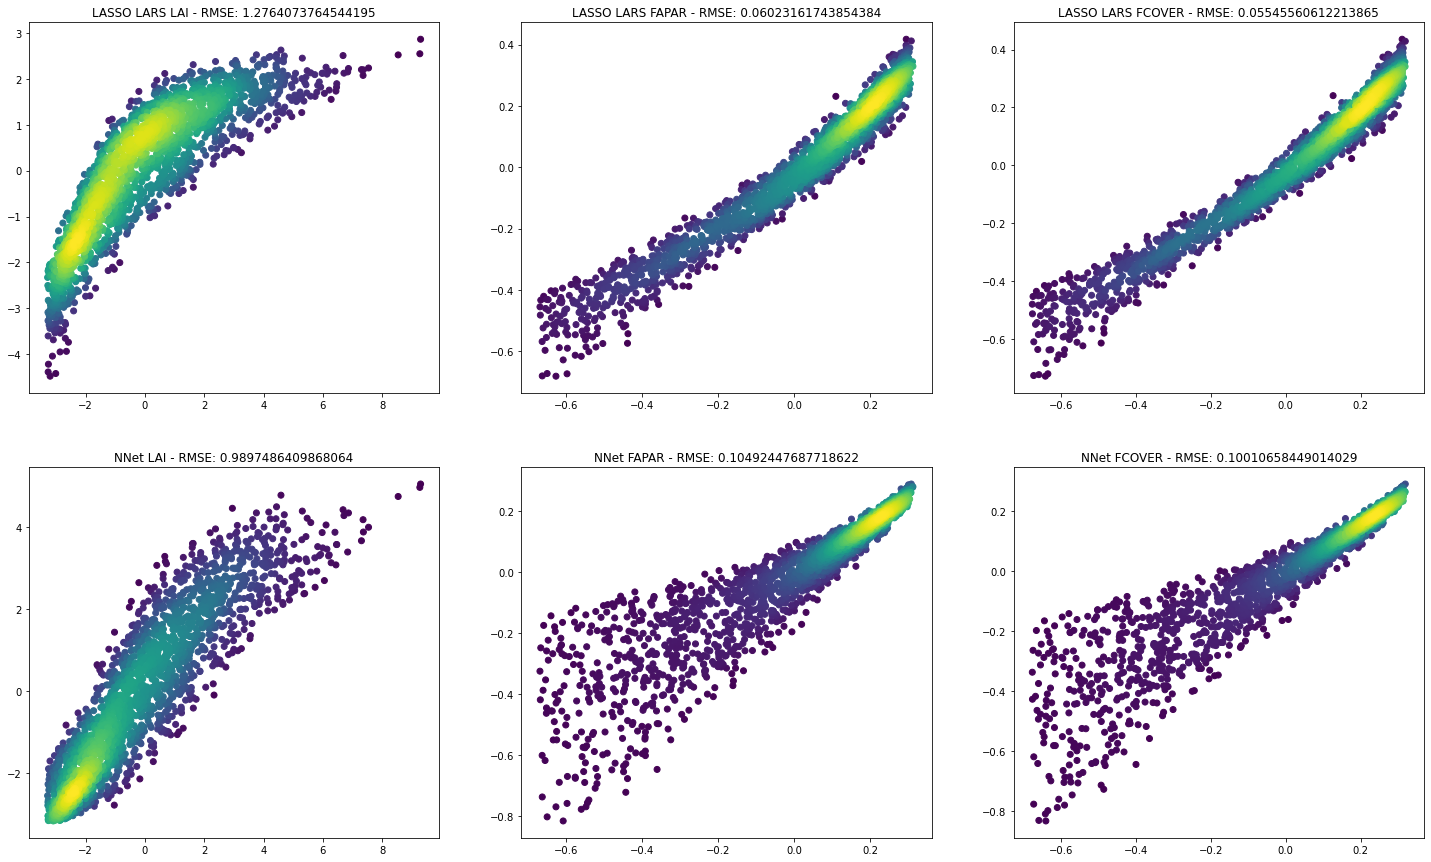

In [36]:
fig, ax = plt.subplots(2, 3, figsize=(25,15))


ax[0,0].scatter(x_skl_LAI, y_skl_LAI, c=z_skl_LAI)
#ax[0,0].plot(a_skl_LAI, a_skl_LAI, c='r')
ax[0,0].set_title('LASSO LARS LAI - RMSE: {}'.format(rmse_skl_LAI))

ax[1,0].scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
#ax[1,0].plot(a_tf_LAI, a_tf_LAI, c='r')
ax[1,0].set_title('NNet LAI - RMSE: {}'.format(rmse_tf_LAI))


ax[0,1].scatter(x_skl_FAPAR, y_skl_FAPAR, c=z_skl_FAPAR)
#ax[0,1].plot(a_skl_FAPAR, a_skl_FAPAR, c='r')
ax[0,1].set_title('LASSO LARS FAPAR - RMSE: {}'.format(rmse_skl_FAPAR))


ax[1,1].scatter(x_tf_FAPAR, y_tf_FAPAR, c=z_tf_FAPAR)
#ax[1,1].plot(a_tf_FAPAR, a_tf_FAPAR, c='r')
ax[1,1].set_title('NNet FAPAR - RMSE: {}'.format(rmse_tf_FAPAR))


ax[0,2].scatter(x_skl_FCOVER, y_skl_FCOVER, c=z_skl_FCOVER)
#ax[0,2].plot(a_skl_FCOVER, a_skl_FCOVER, c='r')
ax[0,2].set_title('LASSO LARS FCOVER - RMSE: {}'.format(rmse_skl_FCOVER))


ax[1,2].scatter(x_tf_FCOVER, y_tf_FCOVER, c=z_tf_FCOVER)
#ax[1,2].plot(a_tf_FCOVER, a_tf_FCOVER, c='r')
ax[1,2].set_title('NNet FCOVER - RMSE: {}'.format(rmse_tf_FCOVER))

#plt.savefig("./matplotlib_outputs/random_sampling.jpg")

In [ ]:
import ee
ee.Initialize()

In [ ]:
def EE_LARS_Regression(assetName, features, response, maxSamples, n_nonzero):
        
    inputCSV = ee.FeatureCollection(assetName)
    inputCSV = inputCSV.toList(count=maxSamples)
    
    def extractBands(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=features).toList()

    def extractVI(feature):
        feature = ee.Feature(feature)
        return feature.toArray(properties=[response]).toList()
    
    inputList = inputCSV.map(extractBands)
    outputList = inputCSV.map(extractVI)
    
    X = ee.Array(inputList)
    y = ee.Array(outputList)
    
    n = X.length().get([0])
    m = X.length().get([1])
    
    
    def centre(output):
        output = ee.Array(output)
        mean = output.reduce(ee.Reducer.mean(), [0]).get([0,0])
        return output.subtract(mean)
        
    def normalize(inputs):
        inputs = ee.Array(inputs)
        
        inputMeans = inputs.reduce(ee.Reducer.mean(), [0])
        inputMeans = inputMeans.repeat(0, n)
        inputs = inputs.subtract(inputMeans)
        inputs = inputs.pow(2).reduce(ee.Reducer.sum(), [0]).pow(-0.5).repeat(0,n).multiply(inputs)
        
        return inputs
    
    X = normalize(X)
    y = centre(y)
    
    def LARSregression(iteration, inputs):
        inputs = ee.Dictionary(inputs)
        prediction = inputs.getArray('prediction')
        coeff_arr = inputs.getArray('coeff_arr')
    
        c = X.matrixTranspose().matrixMultiply(y.subtract(prediction))
        c_abs = c.abs()
        C_max = c_abs.get(c_abs.argmax())

        maxLocs = c_abs.gte(C_max.subtract(0.00001))
        signs = c.divide(c_abs)

        signs_j = maxLocs.multiply(signs).matrixTranspose()
        signs_jc = signs_j.abs().subtract(1).multiply(-1)
        
        A = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_j).toList().get(0))
        A_c = ee.List(ee.Array([ee.List.sequence(0, m.subtract(1))]).mask(signs_jc).toList().get(0))

        signMatrix_j = signs_j.repeat(0, n)

        X_A = X.multiply(signMatrix_j).mask(signs_j)
        j = X_A.length().get([1])
        
        G_A = X_A.matrixTranspose().matrixMultiply(X_A)

        V1_A = ee.Array(ee.List.repeat([1], j))

        G_Ai = G_A.matrixInverse()

        A_A = V1_A.matrixTranspose().matrixMultiply(G_Ai).matrixMultiply(V1_A).get([0,0]).pow(-0.5)

        w_A = G_Ai.matrixMultiply(V1_A).multiply(A_A)

        u_A = X_A.matrixMultiply(w_A)

        a = X.matrixTranspose().matrixMultiply(u_A)

        def computeGammaRRay(index_j):
            minus_j = C_max.subtract(c.get([index_j, 0])).divide(A_A.subtract(a.get([index_j, 0])))
            plus_j = C_max.add(c.get([index_j, 0])).divide(A_A.add(a.get([index_j, 0])))

            gammaRRay = ee.Array([minus_j, plus_j]);
            gammaRRay = gammaRRay.mask(gammaRRay.gte(0))
            gammaRRay = gammaRRay.multiply(-1)

            return gammaRRay.get(gammaRRay.argmax())

        gammaRRay = ee.Array([A_c.map(computeGammaRRay)])
        gamma = gammaRRay.get(gammaRRay.argmax()).multiply(-1)

        prediction = prediction.add(u_A.multiply(gamma))
        coefficients = X.matrixSolve(prediction)

        def setZero(num):
            num = ee.Number(num)
            return ee.Algorithms.If(num.abs().lt(0.0000000001), [0], [num])

        coefficients = ee.Array(ee.List(coefficients.matrixTranspose().toList().get(0)).map(setZero))

        coeff_arr = ee.Array.cat([coeff_arr, coefficients], axis=1)

        outputs = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

        return outputs
    
    
    numIterations = ee.List.sequence(1, n_nonzero)
    prediction = ee.Array(ee.List.repeat([0], n))
    coeff_arr = ee.Array(ee.List.repeat([0], m))
    initial = ee.Dictionary({'prediction':prediction, 'coeff_arr':coeff_arr})

    finalOutputs = numIterations.iterate(LARSregression, initial)
    finalOutputs = ee.Dictionary(finalOutputs)
    finalPrediction = finalOutputs.getArray('prediction')

    coeff_arr = finalOutputs.getArray('coeff_arr')
    coeff_arr = coeff_arr.getInfo()
    coeff_arr = numpy.asarray(coeff_arr)
    
    return coeff_arr

In [ ]:
LAI_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures', 
                              ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'], 
                              'LAI', 
                              50000, 
                              10)

In [ ]:
FAPAR_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures',
                                ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'],
                                'FAPAR', 
                                50000, 
                                10)

In [ ]:
FCOVER_coef = EE_LARS_Regression('users/ccrs2fy2020/rawFeatures', 
                                 ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3'],
                                 'FCOVER', 
                                 50000, 
                                 10)

In [ ]:
LAI_coef = pandas.DataFrame(LAI_coef)
FAPAR_coef = pandas.DataFrame(FAPAR_coef)
FCOVER_coef = pandas.DataFrame(FCOVER_coef)

In [ ]:
LAI_coef

In [ ]:
FAPAR_coef

In [ ]:
FCOVER_coef